In [1]:
import google_trend_data #importing google trend data collector file
from google_trend_data import search_data_collect as goog

import var_treat as vt

import plotly.express as px
import pandas as pd


**Collecting Google Trend Data**

In [2]:
#df_house_index, search_query = goog('house for sale',['CA']).extract_data()

Back up Google Trend data

In [3]:
#Loading the actual house price data
filename = 'search_data.xlsx'

xls=pd.ExcelFile(filename) 
df_house_index = pd.read_excel(xls)
df_house_index = df_house_index.set_index('date')

In [4]:
time_start = 72 #Jan-2010

df_house_index = df_house_index[time_start:]

fig = px.line(df_house_index, color='variable',labels=dict(index="time", value="Level", variable="option"), width=900, height=400)
fig.show()

***Creating The Index***

In [5]:
df_hs_median = vt.Median_decomp(df_house_index) #Median search data
df_hs_median_season = vt.Deseasonalize_STL(df_hs_median)
df_hs_median_season_smooth = vt.ExpSmoother(vt.ExpSmoother(vt.ExpSmoother(df_hs_median_season)))

df_index_main_visual = df_hs_median
df_index_main_visual['Deseason'] = df_hs_median_season
df_index_main_visual['Smooth'] = df_hs_median_season_smooth

fig_2 = px.line(df_index_main_visual, color='variable',labels={"value": "Level","_index": "","variable": ""}, width=800, height=500,title="Decomposed Search Data")
fig_2.show()

***Importing House Price Data***

In [6]:
#Loading the actual house price data
filename = 'hp_2.xlsx'

xls=pd.ExcelFile(filename) 
df_hp = pd.read_excel(xls)
df_hp = df_hp.set_index(pd.Index(df_house_index.T.columns.values[:150])).iloc[:,1:] #the 150 is June-2022 -- No house price data from stats can for july 

Setting up the dataframe

In [7]:
df_main = df_hs_median_season_smooth

lagg = 8

df_main['hp'] = df_hp
df_main['hp_lag'] = df_hp



In [8]:
fig_2 = px.line(df_main, color='variable',labels={"value": "Level","_index": "","variable": ""}, width=800, height=500,title="House Price and Goog Trend Data")
fig_2.show()

***Detrending***

In [9]:
df_main = df_main.pct_change()

series_lagg = {
    'hp': 8,
    'hp_lag': 9,
}

df_main_clean = vt.data_prep(df_main,series_lagg)

In [10]:
fig_2 = px.line(df_main_clean, color='variable',labels={"value": "Level","_index": "","variable": ""}, width=800, height=500,title="House Price Lagg 8 Months to Trend Data")
fig_2.show()

**Analysis**

In [11]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

X = df_main_clean[['index','hp_lag']][:].values
Y = df_main_clean[['hp']].values

# X = df_main_clean_detrend[['index','hp_lag']][:].values
# Y = df_main_clean_detrend[['hp']].values


######Setting the training length
train_size = int(len(X) * 0.30)
train_size

####Splitting the train and test data set
X_train, X_test = X[0:train_size], X[train_size:len(X)]
y_train, y_test = Y[0:train_size], Y[train_size:len(X)]


lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)


print(np.round(mean_squared_error(y_test, y_pred)*100, decimals=3),

#R2 is negative only when the chosen model does not follow the trend of the data, so fits worse than a horizontal line.
r2_score(y_test, y_pred))

0.002 -0.006762354526135939


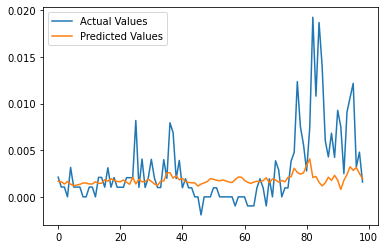

In [12]:
import matplotlib.pyplot as plt

plt.plot(y_test, label="Actual Values")
plt.plot(y_pred, label="Predicted Values")
plt.legend()
plt.show()

In [13]:
import statsmodels.api as sm

log_clf =sm.OLS(y_test,X_test)

classifier = log_clf.fit()

print(classifier.summary2())

                        Results: Ordinary least squares
Model:                  OLS              Adj. R-squared (uncentered): 0.635     
Dependent Variable:     y                AIC:                         -869.0622 
Date:                   2022-08-05 21:12 BIC:                         -863.8720 
No. Observations:       99               Log-Likelihood:              436.53    
Df Model:               2                F-statistic:                 87.17     
Df Residuals:           97               Prob (F-statistic):          2.15e-22  
R-squared (uncentered): 0.643            Scale:                       8.8395e-06
--------------------------------------------------------------------------------------
            Coef.        Std.Err.          t          P>|t|        [0.025       0.975]
--------------------------------------------------------------------------------------
x1          0.1379         0.0649        2.1254       0.0361       0.0091       0.2666
x2          0.7223         0.